# Phase 5: Churn Prediction Modeling

**Objective**: Build and evaluate machine learning models to predict customer churn

**Approach**:
- **Phase 5A**: Data Preparation & VIF Analysis (remove multicollinearity)
- **Phase 5B**: Train 3 Models (Logistic Regression, Random Forest, Gradient Boosting)
- **Phase 5C**: Model Evaluation & Comparison (focus on Recall metric)
- **Phase 5E**: Best Model Selection & Documentation

---

## 1. Import Required Libraries

In [13]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve
)

# VIF Analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Utilities
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


---
# Phase 5A: Data Preparation & VIF Analysis

**Goal**: Load segmented data and remove multicollinearity using VIF (Variance Inflation Factor)

**VIF Threshold**: Remove features with VIF > 10 (indicates high multicollinearity)

## 2. Load Segmented Data

In [14]:
# Load training and test features (with cluster_label from Phase 4)
X_train = pd.read_csv('../data/processed/X_train_with_segments.csv')
X_test = pd.read_csv('../data/processed/X_test_with_segments.csv')

# Load target variables
y_train = pd.read_csv('../data/processed/y_train.csv').values.ravel()
y_test = pd.read_csv('../data/processed/y_test.csv').values.ravel()

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTarget distribution (train): {pd.Series(y_train).value_counts().to_dict()}")
print(f"Target distribution (test): {pd.Series(y_test).value_counts().to_dict()}")

# Check data types
print(f"\nData types:")
print(X_train.dtypes.value_counts())
print(f"\n✅ Data loaded successfully!")

Training set: (5634, 66)
Test set: (1409, 66)

Target distribution (train): {0: 4139, 1: 1495}
Target distribution (test): {0: 1035, 1: 374}

Data types:
int64      46
float64    16
bool        4
Name: count, dtype: int64

✅ Data loaded successfully!


## 3. VIF Analysis - Detect Multicollinearity

**Why VIF?**
- High multicollinearity inflates model coefficients and reduces interpretability
- VIF > 10 indicates problematic correlation between features
- Remove features iteratively until all VIF < 10

In [15]:
def calculate_vif(df):
    """
    Calculate VIF for all features in dataframe
    Note: Requires all numeric data
    """
    # Ensure all columns are numeric (silently filter)
    df_numeric = df.select_dtypes(include=[np.number])
    
    vif_data = pd.DataFrame()
    vif_data['Feature'] = df_numeric.columns
    vif_data['VIF'] = [variance_inflation_factor(df_numeric.values, i) for i in range(len(df_numeric.columns))]
    return vif_data.sort_values('VIF', ascending=False)

# Calculate initial VIF
print("Calculating VIF for all features...\n")
vif_initial = calculate_vif(X_train)

print(f"Features analyzed: {len(vif_initial)} (numeric only)")
print("\nTop 20 features with highest VIF:")
print(vif_initial.head(20))
print(f"\nFeatures with VIF > 10: {len(vif_initial[vif_initial['VIF'] > 10])}")

Calculating VIF for all features...

Features analyzed: 62 (numeric only)

Top 20 features with highest VIF:
                         Feature  VIF
31            StreamingTV_binary  inf
26           is_electronic_check  inf
23                      is_fiber  inf
22                  has_internet  inf
27         OnlineSecurity_binary  inf
28           OnlineBackup_binary  inf
19                    Dependents  inf
18                       Partner  inf
29       DeviceProtection_binary  inf
30            TechSupport_binary  inf
15           loyalty_value_score  inf
13           projected_24m_value  inf
12         family_size_indicator  inf
11  entertainment_services_count  inf
10       security_services_count  inf
9                 total_services  inf
8              avg_monthly_spend  inf
1                 MonthlyCharges  inf
32        StreamingMovies_binary  inf
52             echeck_no_autopay  inf

Features with VIF > 10: 39
Features analyzed: 62 (numeric only)

Top 20 features with highes

## 4. Remove High VIF Features Iteratively

In [16]:
# Iterative VIF removal (remove highest VIF feature until all VIF < 10)
X_train_vif = X_train.select_dtypes(include=[np.number]).copy()  # Only numeric columns
X_test_vif = X_test.select_dtypes(include=[np.number]).copy()
removed_features = []

print("Starting iterative VIF removal...")
print(f"Initial numeric features: {X_train_vif.shape[1]}\n")

iteration = 0
max_iterations = 100  # Safety limit

while iteration < max_iterations:
    vif_df = calculate_vif(X_train_vif)
    max_vif = vif_df['VIF'].max()
    
    if max_vif < 10:
        print(f"\n✅ All features have VIF < 10. Stopping.")
        break
    
    # Remove feature with highest VIF
    feature_to_remove = vif_df.iloc[0]['Feature']
    removed_features.append((feature_to_remove, max_vif))
    
    X_train_vif = X_train_vif.drop(columns=[feature_to_remove])
    X_test_vif = X_test_vif.drop(columns=[feature_to_remove])
    
    iteration += 1
    
    # Print every 5 iterations
    if iteration % 5 == 0:
        print(f"Iteration {iteration}: Removed '{feature_to_remove}' (VIF={max_vif:.2f}), Remaining: {X_train_vif.shape[1]} features")

if iteration >= max_iterations:
    print(f"\n⚠️  Reached maximum iterations ({max_iterations})")

print(f"\nTotal iterations: {iteration}")
print(f"Features removed: {len(removed_features)}")
print(f"Remaining features: {X_train_vif.shape[1]}")

Starting iterative VIF removal...
Initial numeric features: 62

Iteration 5: Removed 'echeck_no_autopay' (VIF=inf), Remaining: 57 features
Iteration 5: Removed 'echeck_no_autopay' (VIF=inf), Remaining: 57 features
Iteration 10: Removed 'revenue_per_month' (VIF=195.60), Remaining: 52 features
Iteration 10: Removed 'revenue_per_month' (VIF=195.60), Remaining: 52 features
Iteration 15: Removed 'MonthlyCharges' (VIF=30.51), Remaining: 47 features
Iteration 15: Removed 'MonthlyCharges' (VIF=30.51), Remaining: 47 features
Iteration 20: Removed 'is_likely_household' (VIF=16.36), Remaining: 42 features
Iteration 20: Removed 'is_likely_household' (VIF=16.36), Remaining: 42 features
Iteration 25: Removed 'PhoneService' (VIF=10.06), Remaining: 37 features
Iteration 25: Removed 'PhoneService' (VIF=10.06), Remaining: 37 features

✅ All features have VIF < 10. Stopping.

Total iterations: 25
Features removed: 25
Remaining features: 37

✅ All features have VIF < 10. Stopping.

Total iterations: 25
Fe

## 5. Review Removed Features

In [17]:
# Create dataframe of removed features
removed_df = pd.DataFrame(removed_features, columns=['Feature', 'VIF'])
print(f"Total removed: {len(removed_df)} features\n")
print(removed_df.to_string())

Total removed: 25 features

                         Feature          VIF
0             StreamingTV_binary          inf
1             TechSupport_binary          inf
2        security_services_count          inf
3                   has_internet          inf
4              echeck_no_autopay          inf
5                   TotalCharges          inf
6               contract_encoded          inf
7            projected_24m_value          inf
8          family_size_indicator  2779.419668
9              revenue_per_month   195.595125
10             avg_monthly_spend    98.260298
11                      is_fiber    81.314549
12                total_services    79.650468
13                        tenure    37.413609
14                MonthlyCharges    30.505753
15               is_new_customer    25.776403
16              has_any_services    22.895266
17                mtm_mid_tenure    20.726973
18                 is_high_price    17.920695
19           is_likely_household    16.359152
20    

## 6. Final VIF Check

In [18]:
# Calculate final VIF for remaining features
vif_final = calculate_vif(X_train_vif)

print(f"Final feature count: {len(vif_final)}")
print(f"\nVIF Summary:")
print(f"  - Max VIF: {vif_final['VIF'].max():.2f}")
print(f"  - Mean VIF: {vif_final['VIF'].mean():.2f}")
print(f"  - Median VIF: {vif_final['VIF'].median():.2f}")
print(f"\nTop 10 features by VIF:")
print(vif_final.head(10))

Final feature count: 37

VIF Summary:
  - Max VIF: 9.39
  - Mean VIF: 4.49
  - Median VIF: 4.75

Top 10 features by VIF:
                 Feature       VIF
1   tenure_group_encoded  9.394887
23        fiber_mtm_risk  8.507746
3       TotalCharges_log  7.514611
36         cluster_label  7.115085
31        is_flight_risk  7.025757
22   long_contract_loyal  6.247000
8       PaperlessBilling  6.064500
28  paperless_no_autopay  6.027615
9                 is_dsl  5.905866
0    contract_risk_score  5.609189


## 7. Visualize VIF Distribution

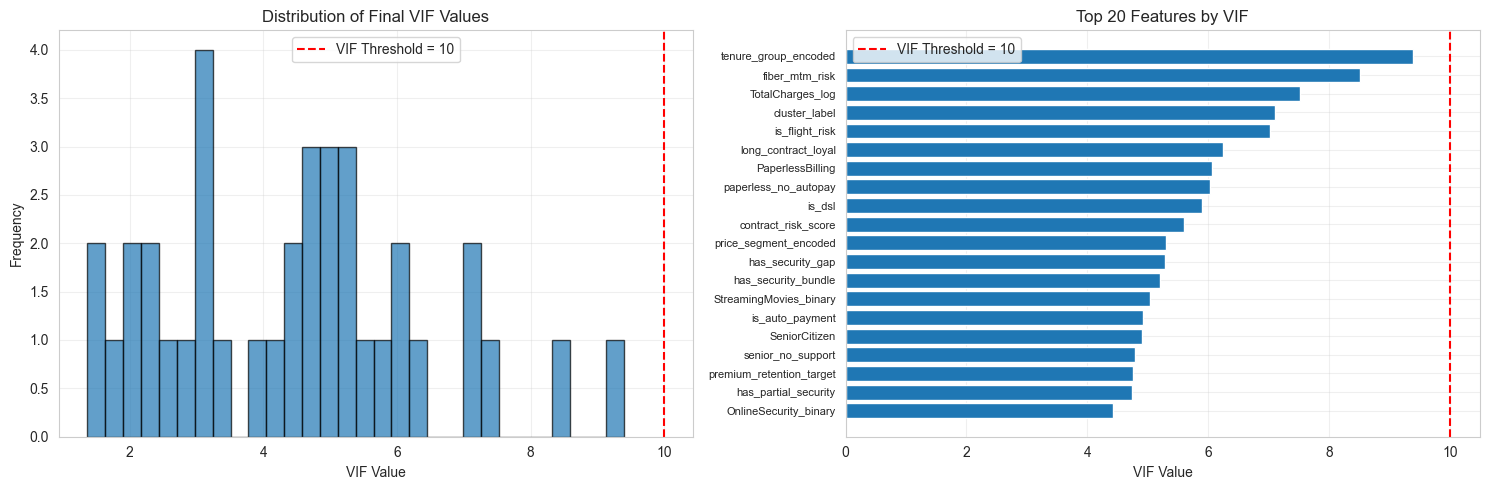

✅ VIF visualization saved to visualizations/phase5a_vif_analysis.png


In [19]:
# Plot VIF distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(vif_final['VIF'], bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(x=10, color='red', linestyle='--', label='VIF Threshold = 10')
axes[0].set_xlabel('VIF Value')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Final VIF Values')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Top 20 features by VIF
top_20 = vif_final.head(20)
axes[1].barh(range(len(top_20)), top_20['VIF'])
axes[1].set_yticks(range(len(top_20)))
axes[1].set_yticklabels(top_20['Feature'], fontsize=8)
axes[1].axvline(x=10, color='red', linestyle='--', label='VIF Threshold = 10')
axes[1].set_xlabel('VIF Value')
axes[1].set_title('Top 20 Features by VIF')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('../visualizations/phase5a_vif_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ VIF visualization saved to visualizations/phase5a_vif_analysis.png")

## 8. Save Cleaned Datasets

In [20]:
# Save VIF-cleaned datasets
X_train_vif.to_csv('../data/processed/X_train_vif_cleaned.csv', index=False)
X_test_vif.to_csv('../data/processed/X_test_vif_cleaned.csv', index=False)

# Save list of removed features
removed_df.to_csv('../data/processed/phase5a_removed_features.csv', index=False)

# Save final VIF values
vif_final.to_csv('../data/processed/phase5a_final_vif.csv', index=False)

print("✅ Datasets saved:")
print(f"  - X_train_vif_cleaned.csv: {X_train_vif.shape}")
print(f"  - X_test_vif_cleaned.csv: {X_test_vif.shape}")
print(f"  - phase5a_removed_features.csv: {len(removed_df)} features")
print(f"  - phase5a_final_vif.csv: {len(vif_final)} features")

✅ Datasets saved:
  - X_train_vif_cleaned.csv: (5634, 37)
  - X_test_vif_cleaned.csv: (1409, 37)
  - phase5a_removed_features.csv: 25 features
  - phase5a_final_vif.csv: 37 features


## 9. Phase 5A Summary

In [21]:
print("=" * 60)
print("PHASE 5A: DATA PREPARATION & VIF ANALYSIS - COMPLETE")
print("=" * 60)
print(f"\n📊 Dataset Transformation:")
print(f"  - Initial features: {X_train.shape[1]}")
print(f"  - Features removed (VIF > 10): {len(removed_features)}")
print(f"  - Final features: {X_train_vif.shape[1]}")
print(f"  - Reduction: {len(removed_features) / X_train.shape[1] * 100:.1f}%")
print(f"\n📈 VIF Statistics:")
print(f"  - Max VIF: {vif_final['VIF'].max():.2f}")
print(f"  - Mean VIF: {vif_final['VIF'].mean():.2f}")
print(f"  - All features now have VIF < 10 ✓")
print(f"\n💾 Deliverables:")
print(f"  - X_train_vif_cleaned.csv ({X_train_vif.shape[0]} rows × {X_train_vif.shape[1]} features)")
print(f"  - X_test_vif_cleaned.csv ({X_test_vif.shape[0]} rows × {X_test_vif.shape[1]} features)")
print(f"  - phase5a_removed_features.csv (removed features log)")
print(f"  - phase5a_final_vif.csv (VIF values for all remaining features)")
print(f"  - phase5a_vif_analysis.png (visualization)")
print(f"\n✅ Ready for Phase 5B: Model Training!")
print("=" * 60)

PHASE 5A: DATA PREPARATION & VIF ANALYSIS - COMPLETE

📊 Dataset Transformation:
  - Initial features: 66
  - Features removed (VIF > 10): 25
  - Final features: 37
  - Reduction: 37.9%

📈 VIF Statistics:
  - Max VIF: 9.39
  - Mean VIF: 4.49
  - All features now have VIF < 10 ✓

💾 Deliverables:
  - X_train_vif_cleaned.csv (5634 rows × 37 features)
  - X_test_vif_cleaned.csv (1409 rows × 37 features)
  - phase5a_removed_features.csv (removed features log)
  - phase5a_final_vif.csv (VIF values for all remaining features)
  - phase5a_vif_analysis.png (visualization)

✅ Ready for Phase 5B: Model Training!


---
# Phase 5B: Model Training

**Coming Next**: Train 3 models on VIF-cleaned data
1. Logistic Regression (baseline, interpretable)
2. Random Forest (ensemble, handles non-linearity)
3. Gradient Boosting (advanced, typically best performance)